# Credit Risk Analysis

# Importing Necessary Libraries

This section imports all the required Python libraries for data analysis, preprocessing, modeling, and visualization. Key libraries include:
- `numpy` and `pandas` for numerical computations and data manipulation.
- `sklearn` for machine learning pipelines, preprocessing, model training, and evaluation.
- `xgboost` for gradient boosting models.
- `shap` for model interpretability.
- `matplotlib` and `seaborn` for visualizations.
- `imblearn` for handling imbalanced datasets using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading and Exploring the Dataset

In this section, we load the credit risk dataset and perform an initial exploration to understand its structure and characteristics:
- **Dataset Info**: Provides an overview of the dataset, including column names, data types, and non-null counts.
- **Sample Data**: Displays the first few rows of the dataset to give a sense of the data format.
- **Basic Statistics**: Summarizes key statistical metrics (mean, median, standard deviation, etc.) for numerical columns.
- **Missing Values**: Checks for missing values in the dataset.
- **Default Rate**: Calculates the proportion of borrowers who have defaulted (`default = 1`).

This exploration helps us identify potential issues such as missing values, outliers, or class imbalance.

In [16]:
# Load data with proper date formatting
df= pd.read_csv('../input/loan-data/Task 3 and 4_Loan_Data.csv')

In [17]:

 # Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nSample of data:")
print(df.head())
    
# Basic statistics
print("\nBasic statistics:")
print(df.describe())
    
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())
    
# Calculate default rate
default_rate = df['default'].mean()
print(f"\nDefault rate: {default_rate:.2%}")
    

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB
None

Sample of data:
   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.0

# Visualizing Relationships in the Data

This section creates several plots to better understand the relationships between features and the target variable (`default`):
- **Correlation Matrix**: Shows the pairwise correlations between numerical features, helping to identify multicollinearity and important predictors.
- **FICO Score Distribution by Default Status**: Compares the distribution of FICO scores for defaulters and non-defaulters using a boxplot.
- **Loan Amount vs Income**: A scatterplot to visualize the relationship between loan amount and income, with points colored by default status.
- **Default Rate by Credit Lines**: A bar chart showing how the default rate varies with the number of credit lines outstanding.

These visualizations provide insights into feature importance and potential patterns in the data.

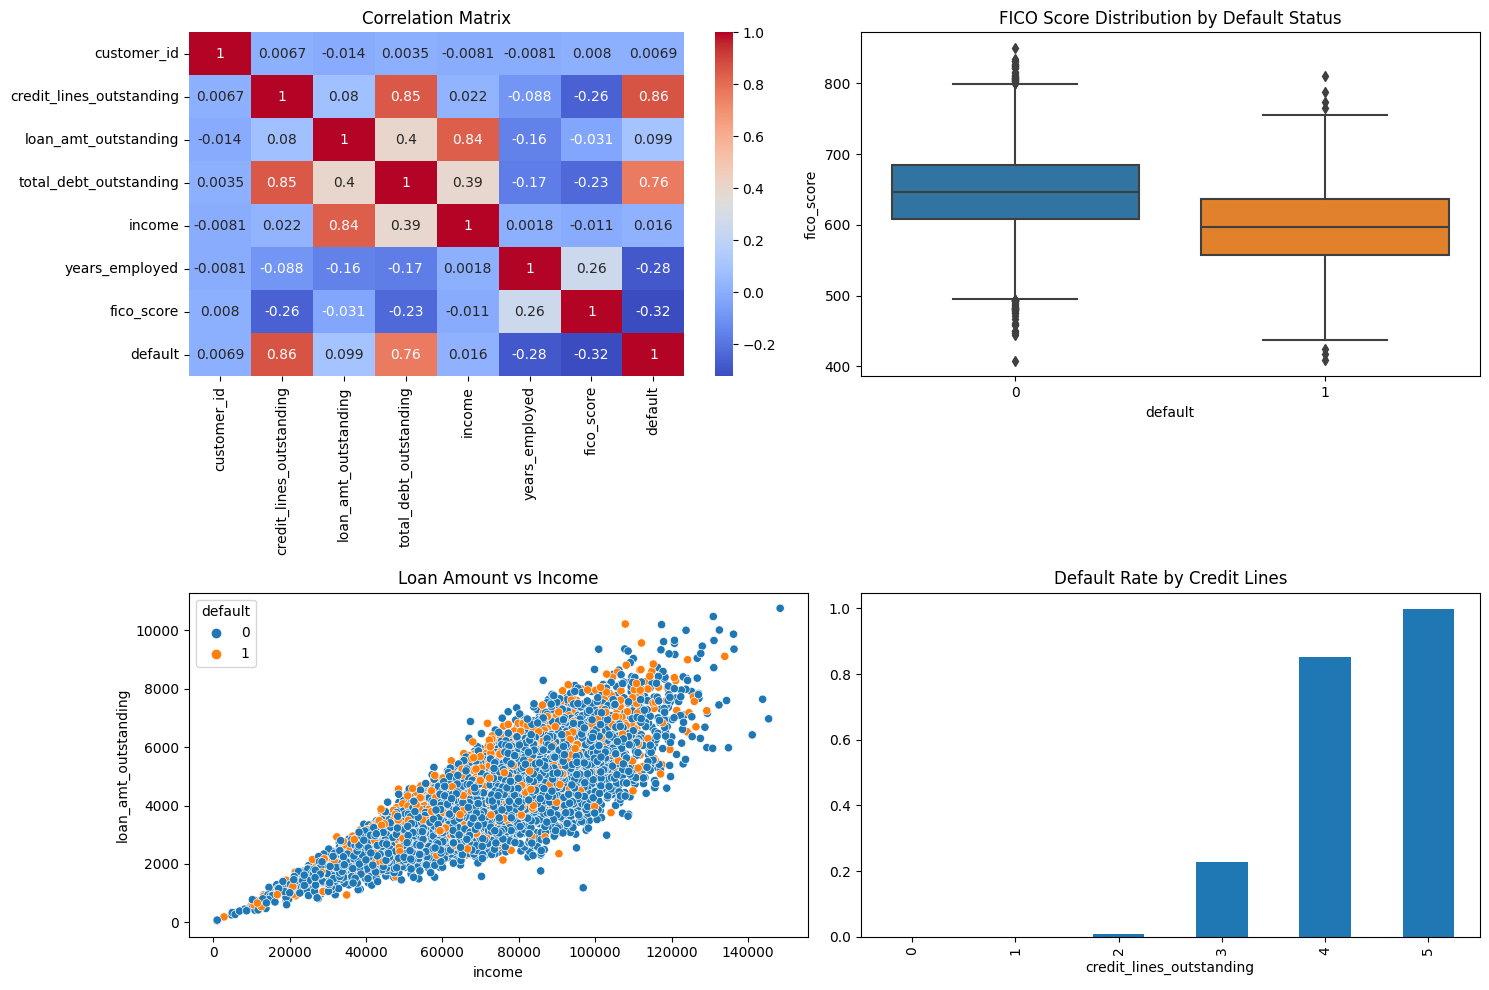

In [18]:

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
    
# Correlation matrix
plt.subplot(2, 2, 1)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
    
# Distribution of FICO scores by default status
plt.subplot(2, 2, 2)
sns.boxplot(x='default', y='fico_score', data=df)
plt.title('FICO Score Distribution by Default Status')
    
# Relationship between loan amount and income
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='income', y='loan_amt_outstanding', hue='default')
plt.title('Loan Amount vs Income')
    
# Default rate by credit lines
plt.subplot(2, 2, 4)
df.groupby('credit_lines_outstanding')['default'].mean().plot(kind='bar')
plt.title('Default Rate by Credit Lines')
    
plt.tight_layout()
plt.show()



# Data Preprocessing

This section prepares the data for modeling by performing the following steps:
- **Feature Engineering**:
  - Creates new features such as `debt_to_income`, `loan_to_debt_ratio`, and `fico_bin` (binned FICO scores).
  - Handles outliers using the Interquartile Range (IQR) method.
- **Preprocessing Pipeline**:
  - Uses `ColumnTransformer` to apply different preprocessing steps to numerical and categorical features:
    - Numerical features are standardized using `StandardScaler`.
    - Categorical features are one-hot encoded using `OneHotEncoder`.

The preprocessing pipeline ensures that the data is clean, normalized, and ready for machine learning models.

In [19]:
# Load and preprocess data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df['debt_to_income'] = df['total_debt_outstanding'] / (df['income'] + 1e-6)
    df['loan_to_debt_ratio'] = df['loan_amt_outstanding'] / (df['total_debt_outstanding'] + 1e-6)
    df['fico_bin'] = pd.cut(df['fico_score'], bins=[300, 580, 670, 740, 850], labels=['Poor', 'Fair', 'Good', 'Excellent'])
    
    for col in ['loan_amt_outstanding', 'income', 'total_debt_outstanding']:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = np.where(df[col] > q3 + 1.5 * iqr, q3 + 1.5 * iqr, df[col])
        df[col] = np.where(df[col] < q1 - 1.5 * iqr, q1 - 1.5 * iqr, df[col])
    
    return df

In [20]:
# Preprocessing pipeline
def create_preprocessor():
    numeric_features = ['credit_lines_outstanding', 'loan_amt_outstanding',
                        'total_debt_outstanding', 'income', 'years_employed',
                        'debt_to_income', 'loan_to_debt_ratio']
    categorical_features = ['fico_bin']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    return preprocessor


# Model Training and Evaluation

In this section, we train and evaluate multiple machine learning models to predict the probability of default:
- **Models Trained**:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost
- **Handling Class Imbalance**:
  - Uses SMOTE to oversample the minority class (defaulters) during training.
- **Evaluation Metrics**:
  - ROC AUC: Measures the ability of the model to distinguish between classes.
  - PR AUC: Focuses on precision-recall trade-offs, especially useful for imbalanced datasets.
  - Precision-Recall Curve: Provides a detailed view of the model's performance across different thresholds.
- **Feature Importance**:
  - For tree-based models (Decision Tree, Random Forest, XGBoost), we visualize the top 10 most important features.
- **SHAP Analysis**:
  - Uses SHAP (SHapley Additive exPlanations) to interpret the impact of each feature on the model's predictions.

The results of each model are stored and compared to identify the best-performing model.

In [21]:
# Model training and evaluation
def train_and_evaluate(df):
    features = ['credit_lines_outstanding', 'loan_amt_outstanding',
                'total_debt_outstanding', 'income', 'years_employed',
                'debt_to_income', 'loan_to_debt_ratio', 'fico_bin']
    X = df[features]
    y = df['default']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    preprocessor = create_preprocessor()
    
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=np.sum(y == 0) / np.sum(y == 1))
    }
    
    calibrated_lr = CalibratedClassifierCV(models['Logistic Regression'], method='isotonic', cv=3)
    
    results = {}
    
    for name, model in models.items():
        pipeline = make_imb_pipeline(
            preprocessor,
            SMOTE(sampling_strategy='minority'),
            model if name != 'Logistic Regression' else calibrated_lr
        )
        
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        results[name] = {
            'model': pipeline,
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'pr_auc': average_precision_score(y_test, y_pred_proba),
            'precision_recall': precision_recall_curve(y_test, y_pred_proba)
        }
        
        if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            numeric_features = ['credit_lines_outstanding', 'loan_amt_outstanding',
                                'total_debt_outstanding', 'income', 'years_employed',
                                'debt_to_income', 'loan_to_debt_ratio']
            categorical_features = ['fico_bin']
            
            if name == 'XGBoost':
                importances = pipeline.named_steps['xgbclassifier'].feature_importances_
            else:
                importances = model.feature_importances_
            
            feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
            feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
            
            plt.figure(figsize=(10, 6))
            feat_imp.head(10).plot(kind='bar')
            plt.title(f'Feature Importance - {name}')
            plt.show()
    
    explainer = shap.TreeExplainer(pipeline.named_steps['xgbclassifier'])
    shap_values = explainer.shap_values(preprocessor.transform(X_train))
    
    plt.title('SHAP Summary Plot')
    shap.summary_plot(shap_values, preprocessor.transform(X_train), feature_names=feature_names)
    
    return results

# Expected Loss Calculation

This section defines a function to calculate the expected loss for a given loan:
- **Inputs**:
  - A trained model.
  - Loan data, including features such as `loan_amt_outstanding`, `income`, `fico_bin`, etc.
  - Recovery rate (default is 10%).
- **Formula**:
  - Expected Loss = Probability of Default × Loss Given Default (LGD) × Exposure at Default (EAD).
  - LGD = 1 - Recovery Rate.
  - EAD = Loan Amount Outstanding.

This function allows us to estimate the financial risk associated with a specific loan based on the model's predicted probability of default.

In [22]:
# Expected loss calculation
def predict_expected_loss(model, loan_data, recovery_rate=0.1):
    loan_df = pd.DataFrame([loan_data])
    proba = model.predict_proba(loan_df)[0][1]
    exposure = loan_data['loan_amt_outstanding']
    lgd = 1 - recovery_rate
    return proba * lgd * exposure

# Example Usage

This section demonstrates how to use the trained models and functions:
- Loads and preprocesses the dataset.
- Trains multiple models and evaluates their performance using ROC AUC and PR AUC.
- Selects the best-performing model (e.g., XGBoost) and calculates the expected loss for a sample loan.

The output includes:
- Performance metrics for each model.
- The expected loss for the sample loan, providing a concrete example of how the model can be applied in practice.

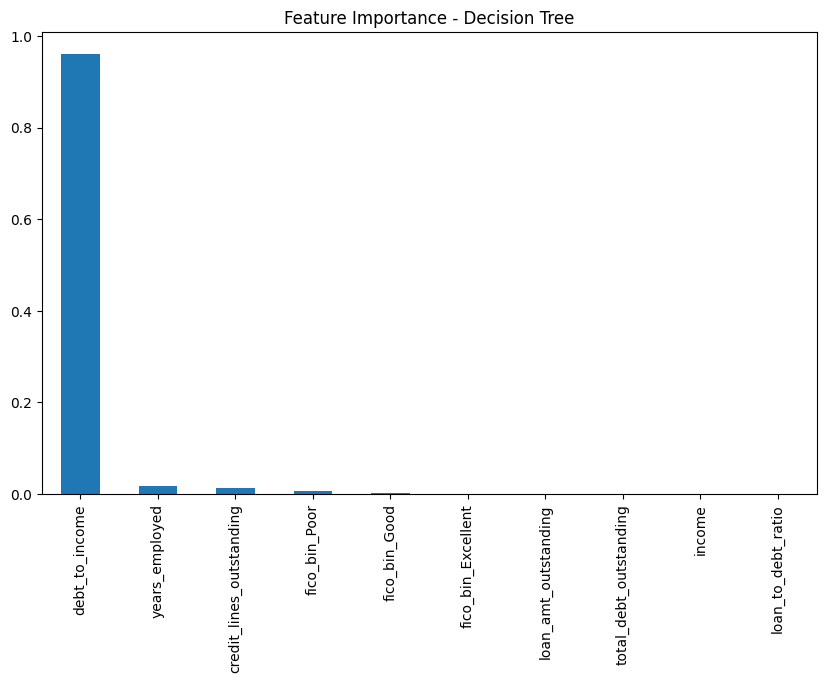

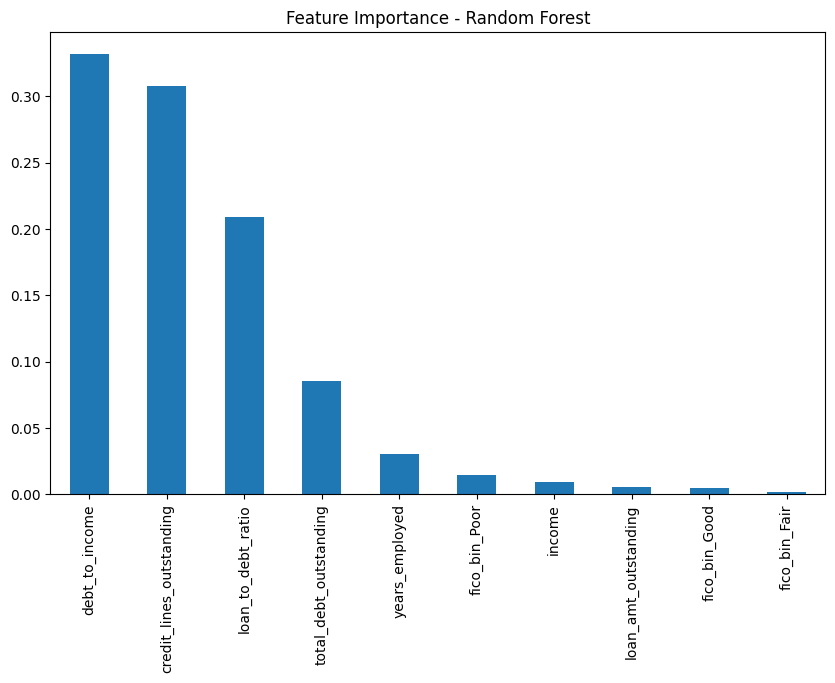

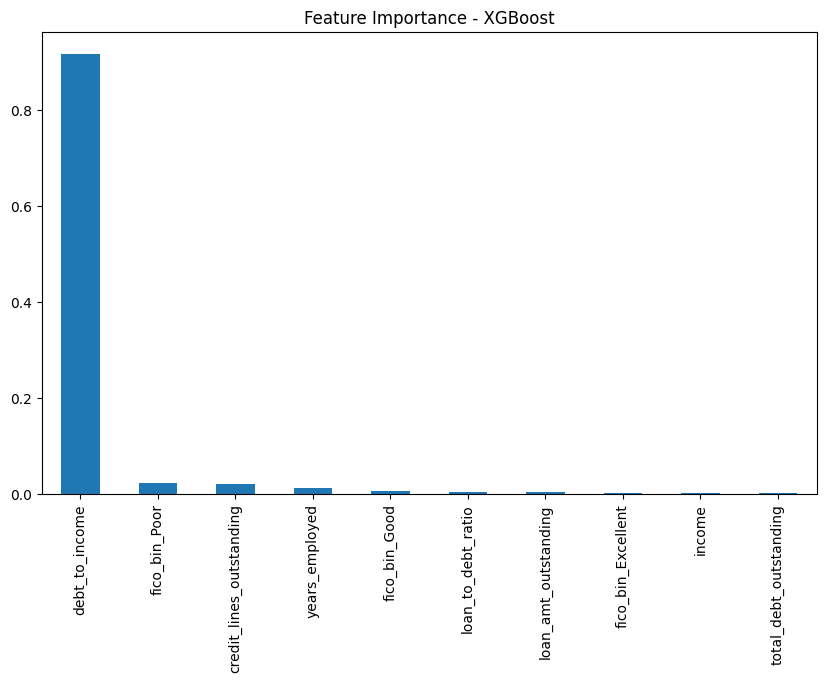

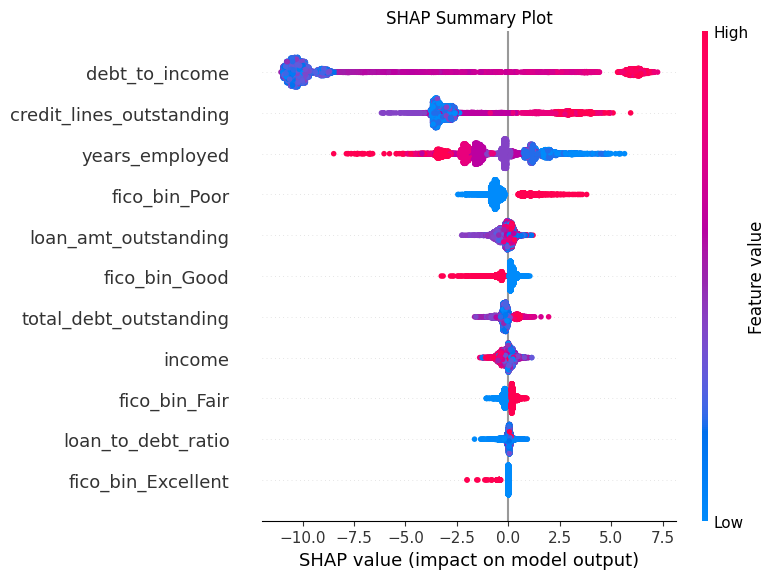


Model Performance Comparison:
Logistic Regression:
  ROC AUC: 1.000
  PR AUC: 1.000

Decision Tree:
  ROC AUC: 0.999
  PR AUC: 0.995

Random Forest:
  ROC AUC: 1.000
  PR AUC: 0.999

XGBoost:
  ROC AUC: 1.000
  PR AUC: 0.999

Expected Loss for Sample Loan: $44884.37


In [23]:
# Example usage
if __name__ == "__main__":
    df = load_and_preprocess('../input/loan-data/Task 3 and 4_Loan_Data.csv')
    results = train_and_evaluate(df)
    
    print("\nModel Performance Comparison:")
    for name, metrics in results.items():
        print(f"{name}:")
        print(f"  ROC AUC: {metrics['roc_auc']:.3f}")
        print(f"  PR AUC: {metrics['pr_auc']:.3f}\n")
    
    sample_loan = {
        'credit_lines_outstanding': 3,
        'loan_amt_outstanding': 50000,
        'total_debt_outstanding': 100000,
        'income': 80000,
        'years_employed': 5,
        'fico_bin': 'Good',
        'debt_to_income': 100000 / 80000,
        'loan_to_debt_ratio': 50000 / 100000
    }
    
    best_model = results['XGBoost']['model']
    expected_loss = predict_expected_loss(best_model, sample_loan)
    print(f"Expected Loss for Sample Loan: ${expected_loss:.2f}")